Notebook for  pieces to Figure 2 and associated Supplementary Figures

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from scipy.ndimage import gaussian_filter

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
import mkl


In [8]:
mkl.set_num_threads(8)

48

In [9]:
import enrichment_stats

## Functions

In [10]:
from upsetplot import plot as UpSet
def upset_from_design(design):
    """Create upset plots from design matricies
        Creates upset plots from design matricies. 

        For example if you have meta-analytic cell type labels across datasets,
        the datasets are rows and the cell-types are columns with booleans for membership
    Arguments:
        design {pandas.DataFrame} -- Dataframe with groups as rows, and features as columns

    Returns:
        us -- Upset plot object
    """
    membership = {
    k: np.array(list(v.keys()))[np.array(list(v.values()))]
    for k, v in design.to_dict().items()
    }
    df = pd.DataFrame([{name: True
                    for name in names} for names in membership.values()],
                  index=membership.keys())
    df = df.fillna(False)
    df = df.groupby(df.columns.tolist(), as_index=False).size()

    cols = df.columns[:-1].copy()
    for col in cols:
        df.set_index(df[col], append=True, inplace=True)
    df.index = df.index.droplevel(0)
    df= df['size']
    us = UpSet(df, sort_by='cardinality')
    return us

In [602]:
def order_rows_according_to_cols(M, alpha=1.0):
    """Helper function for clustering rows
    Cluster rows to make high values along the diagonal
    Arguments:
    M {pd.DataFrame} -- Dataframe with columns order how they will be plotted
    Keyword Arguments:
    alpha {number} -- Power to raise dataframe to, higher gives more weight to extreme values (default: {1})
    Returns:
    np.ndarray -- 1-D array with order for rows
    """
    M2 = M.values**alpha
    row_score = np.nansum(M2.T * np.arange(M2.shape[1])[:, None],
                          axis=0) / np.nansum(M2, axis=1)
    return M.index[np.argsort(row_score)]

def plotDotPlot(adata,
                gene_set,
                ax,
                normalize_library_size=True,
                mn_key="MetaNeighbor",
                study_col=None,
                ct_col=None,
                alpha_row=10,
                average_expressing_only=True,
                figsize=(10, 6),
                fontsize=10,
                show=True,
                **kwargs):
    """Plot dot plot showing expression of a gene set across cell types.
    The size of each dot reflects the number of cell that express a gene,
    the color reflects the average expression.
    Expression of genes is first average and scaled in each dataset
    independently. The final value is obtained by averaging across datasets.
    Arguments:
        adata {AnnData} -- AnnData object containing expression and metadata
        gene_set {pd.Series} -- Boolean pd.Series with genes as index and Genes that are in the geneset as True
    Keyword Arguments:
        normalize_library_size {bool} -- Wheter to normalize cells by library size (default: {True})
        mn_key {str} -- Locatoin of MetaNeighborUS results to get params data (default: {'MetaNeighbor'})
        study_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['study_col'],
            else vector of study ids (default: {None})
        ct_col {vector} -- If none, inferrefed from adata.uns[f'{mn_key}_params']['ct_col'],
            else vector of cell type labels (default: {None})
        alpha_row {number} -- Parameter controling row ordering: a higher value of
            alpha_row gives more weight to extreme AUROC values (close to 1) (default: {10})
        average_expressing_only {bool} -- Whether average expression should be computed based
            only on expressing cells (Seurat default) or taking into account zeros (default: {True})
        figsize {tuple} -- Tuple that sets figure size in inches (default: {(10,6)})
        fontsize {number} -- Fontsize of gene names in y axis ticks (default: {10})
        show {bool} -- If True shows plot, else returns ax (default: {True})
    """
    if study_col is None:
        study_col = adata.uns[f"{mn_key}_params"]["study_col"]
    else:
        assert study_col in adata.obs_keys(), "Must pass study col in obs keys"
    if ct_col is None:
        ct_col = adata.uns[f"{mn_key}_params"]["ct_col"]
    else:
        assert ct_col in adata.obs_keys(), "Must pass ct col in obs keys"

    gs = gene_set.index[gene_set.astype(bool)]
    gs = np.intersect1d(gs, adata.var_names)

    if normalize_library_size:
        expr = adata[:, gs].to_df().T
        expr /= np.ravel(adata.X.sum(axis=1)) * 1e6

    else:
        expr = adata[:, gs].to_df().T

    label_matrix = pymn.utils.design_matrix(
        pymn.utils.join_labels(adata.obs[study_col].values, adata.obs[ct_col].values))
    label_matrix /= label_matrix.sum()
    centroids = pd.DataFrame(
        expr.fillna(0).values.astype(float)
        @ label_matrix.values.astype(float),
        index=expr.index,
        columns=label_matrix.columns,
    )
    average_nnz = pd.DataFrame(
        ((expr.fillna(0).values > 0).astype(float) @ label_matrix.values),
        index=expr.index,
        columns=label_matrix.columns,
    )
    if average_expressing_only:
        centroids /= average_nnz
    centroids = centroids.T.astype(float).apply(stats.zscore,
                                                nan_policy='omit').T
    centroids.index.name = "Gene"
    average_nnz.index.name = "Gene"

    centroids.reset_index(inplace=True)
    average_nnz.reset_index(inplace=True)

    pheno, _, _ = pymn.utils.create_cell_labels(adata, study_col, ct_col)
    pheno.set_index("study_ct", inplace=True)
    pheno2 = pheno.drop_duplicates()

    centroids = pd.melt(centroids,
                        id_vars="Gene",
                        value_name="Average Expression",
                        var_name="study_ct")
    centroids.loc[:, "Cell Type"] = pheno2.loc[centroids["study_ct"].
                                               values, ct_col].values
    centroids = centroids.groupby(["Gene", "Cell Type"]).agg({
        'Average Expression':
        lambda x: x.mean(skipna=False)
    }).reset_index()

    average_nnz = pd.melt(
        average_nnz,
        id_vars="Gene",
        value_name="Percent Expressing",
        var_name="study_ct",
    )
    average_nnz.loc[:, "Cell Type"] = pheno2.loc[average_nnz["study_ct"].
                                                 values, ct_col].values

    average_nnz = average_nnz.groupby(["Gene",
                                       "Cell Type"]).mean().reset_index()
    result = centroids.merge(average_nnz,
                             how="inner",
                             on=["Gene", "Cell Type"])

    row_order = order_rows_according_to_cols(
        pd.pivot(result,
                 index="Gene",
                 columns="Cell Type",
                 values="Average Expression"),
        alpha=10,
    )[::-1]
    result.loc[:, "Gene"] = pd.Categorical(result.Gene, categories=row_order)

    result.sort_values("Gene", inplace=True)

    result.loc[:, "Gene"] = result["Gene"].astype(str)

    gene_cat = pd.Categorical(result.Gene, categories=result.Gene.unique())
    result.loc[:, 'Gene_pos'] = gene_cat.codes + 1
    cell_cat = result['Cell Type'].astype('category').cat
    result.loc[:, 'Cell_pos'] = cell_cat.codes + 1
    breaks = np.abs(result['Average Expression'].fillna(0)).max()
    sns.scatterplot(data=result.fillna(0),
                    x='Cell_pos',
                    y='Gene_pos',
                    hue='Average Expression',
                    size='Percent Expressing',
                    palette='vlag',
                    vmin=breaks*-1,
                    vmax=breaks,
                    ax=ax,
                    **kwargs)
    ax.legend(loc=(1, 0), frameon=False)
    resna = result[result.isna().any(axis=1)]

    sns.scatterplot(data=resna.fillna(0),
                    x='Cell_pos',
                    y='Gene_pos',
                    size='Percent Expressing',
                    ax=ax,
                    color='.7',
                    legend=None,
                    **kwargs)

    ax.set(xlabel='Cell Type', ylabel='Gene')
    ax.set_xticks(result['Cell_pos'].unique())
    ax.set_xticklabels(result['Cell Type'].unique())
    ax.set_yticks(result['Gene_pos'].unique())
    ax.set_yticklabels(result['Gene'].unique())
    if show:
        plt.show()
    else:
        return ax

## Load Data

In [666]:
all_droplet = sc.read_loom(
    '/home/bharris/pseudotime/data/processed_droplet_data.loom')

datasets_used = all_droplet.obs.study_id.unique()
datasets_used = datasets_used[~np.in1d(datasets_used, ['tmSS', 'tm10x'])]
all_droplet = all_droplet[all_droplet.obs.study_id.isin(datasets_used)]

remove_num = np.vectorize(lambda x: '-'.join(x.split('-')[:-1]))
all_droplet.obs_names = remove_num(all_droplet.obs_names)

all_droplet.obs['Study'] = [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in all_droplet.obs.study_id]

## Creating the markers
Run the Rscript `droplet_markers.r` before running the figures section below to compute the correct marker genes

## Figures

In [668]:
study_ct_design = (pd.get_dummies(all_droplet.obs[['scNym','Study']]
                .drop_duplicates()
                .set_index('Study'))
 .reset_index()
 .groupby('Study')
 .sum())

study_ct_design.columns = [x.split('_')[1] for x in study_ct_design.columns]

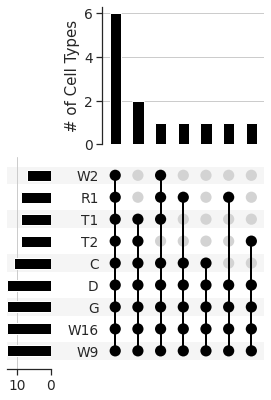

In [670]:

up = upset_from_design(study_ct_design.astype(bool))
up['intersections'].set(ylabel='# of Cell Types')
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/scNym_ds_upset.pdf',
            transparent=True)

In [674]:
scNym_pal = dict(zip(np.sort(all_droplet.obs.scNym.unique()), 
                     sns.color_palette(all_droplet.uns['scNym_colors'])))

pd.Series(scNym_pal).to_csv('/home/bharris/pseudotime/data/tabula_muris_cell_type_pal.csv')

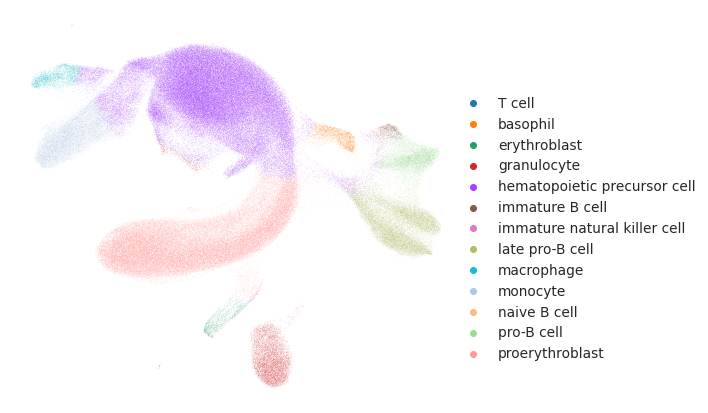

In [675]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=all_droplet.obsm['X_umap'][:,0],
                y=all_droplet.obsm['X_umap'][:,1],
                hue=all_droplet.obs.scNym,
                palette=scNym_pal,
                edgecolor='none',
                linewidth=0,
                alpha=1,
                s = 20000/all_droplet.shape[0],
                rasterized=True,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,0.1),frameon=False)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/scNym_clusters_umap.pdf',
            transparent=True)

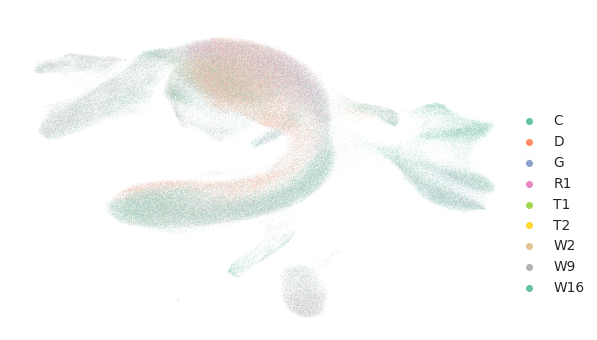

In [676]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = all_droplet.obsm['X_umap'][:,0],
                y = all_droplet.obsm['X_umap'][:,1], 
                hue = all_droplet.obs.Study,
                palette='Set2',

                s = 20000/all_droplet.shape[0],
                rasterized=True,
                alpha=1,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,.1), frameon=False)
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/scNym_datasets_umap.pdf',
            transparent=True)

## Unfiltered Data

In [657]:
unfiltered = sc.read('/home/bharris/pseudotime/data/droplet_expression/unfiltered_combined_droplet_scNym_results.loom')
unfiltered.obs['Study'] = [x if x in ['tm10x','tmSS'] else (x[0] + ''.join(re.findall(r'\d+',x))).upper() for x in unfiltered.obs.study_id]

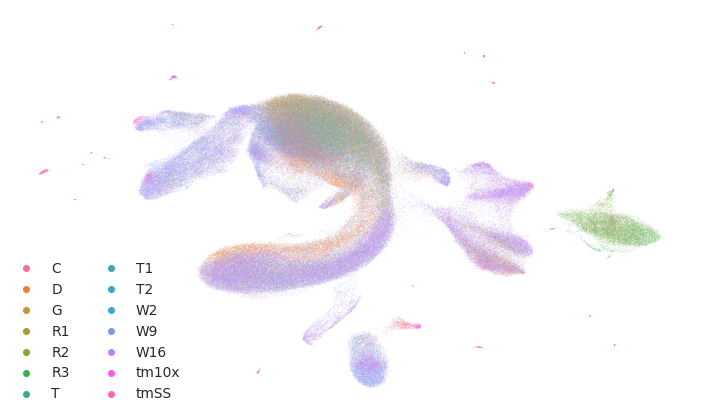

In [785]:
study_order = np.unique(unfiltered.obs.Study)
study_order[9:12] = ['W2','W9','W16']

fig , ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = unfiltered.obsm['X_umap'][:,0],
                y = unfiltered.obsm['X_umap'][:,1], 
                hue = unfiltered.obs.Study,
                hue_order=study_order,
                rasterized=True,
                s = 120000/unfiltered.shape[0],
                alpha=.3,
                ax=ax)
ax.axis('off')
ax.legend(loc=(0,0),frameon=False,ncol=2)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/integration/scNym_datasets_umap_unfiltered.pdf',
            transparent=True)

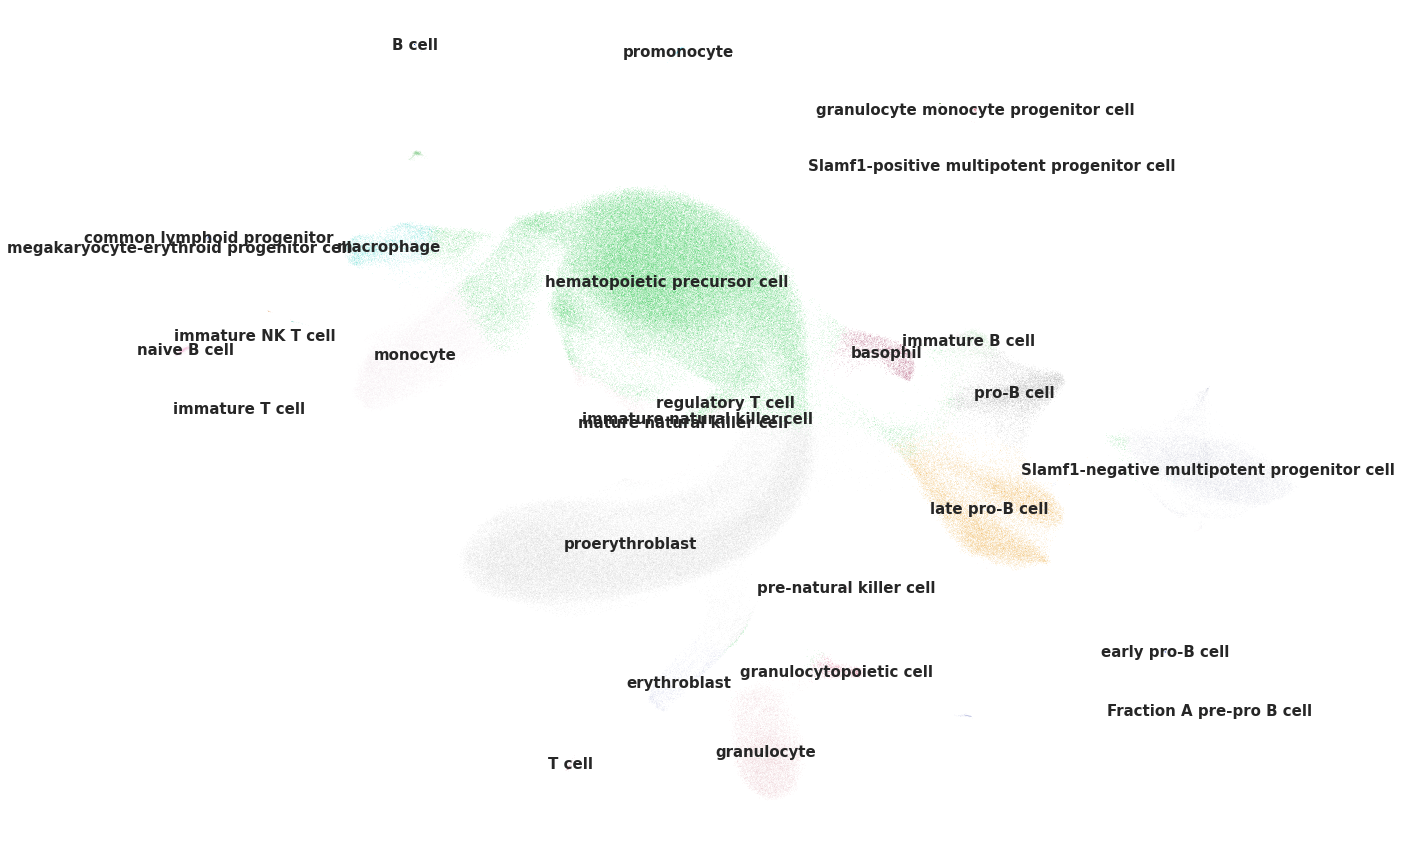

In [794]:
fig, ax = plt.subplots(figsize=(20,12))
sc.pl.umap(unfiltered,
           color='scNym',
           legend_loc='on data',
           ax=ax,
           show=False)
ax.axis('off')
ax.set(title='')
ax.set_rasterized(True)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/integration/integrated_cell_type_labels.pdf',transparent=True)

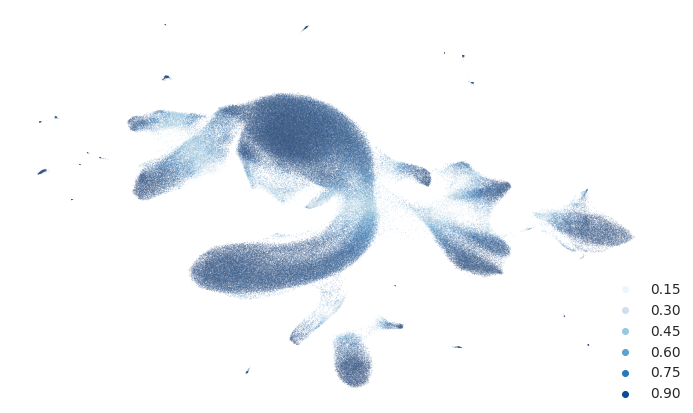

In [770]:
fig , ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = unfiltered.obsm['X_umap'][:,0],
                y = unfiltered.obsm['X_umap'][:,1], 
                hue = unfiltered.obs.scNym_confidence,
                rasterized=True,
                s = 120000/unfiltered.shape[0],
                alpha=.3,
                palette='Blues',
                ax=ax)
ax.axis('off')
ax.legend(loc=(.91,0),frameon=False)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/integration/scNyn_confidence.pdf',
            transparent=True)


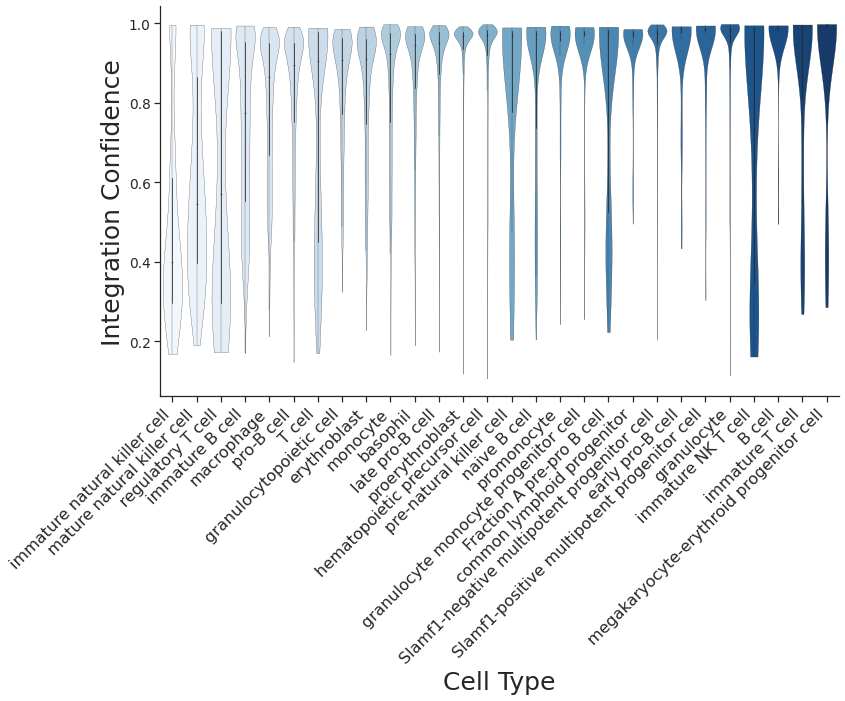

In [899]:
fig, ax = plt.subplots(figsize=(12,10))
sns.violinplot(data=unfiltered.obs,
              x='scNym',
              y='scNym_confidence',
              scale='width',
              order=unfiltered.obs.groupby('scNym')['scNym_confidence'].median().sort_values().index,
              palette='Blues',
               cut=0,
              linewidth=.25,
              ax=ax)
ax.set_xlabel('Cell Type',fontsize=25)
ax.set_ylabel('Integration Confidence', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(),ha='right',rotation=45,fontsize=16)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/integration/scNym_confidence_violinplot.pdf',
            transparent=True)

In [705]:
excluded_cts = unfiltered.obs.scNym.unique()[~np.in1d(unfiltered.obs.scNym.unique(),
                                                      np.array(list(scNym_pal.keys())))]
excluded_filter = unfiltered.obs.scNym.isin(excluded_cts)

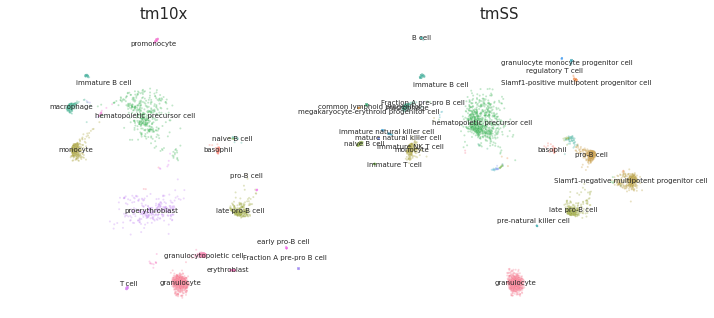

In [775]:

g = sns.relplot(x = unfiltered.obsm['X_umap'][:,0],
                y = unfiltered.obsm['X_umap'][:,1], 
                hue = unfiltered.obs.scNym,
                col= unfiltered.obs.Study,
                col_order=['tm10x','tmSS'],
                rasterized=True,
                legend = False,
                s = 1200000/unfiltered.shape[0],
                alpha=.3)
for ax, study in zip(g.fig.axes,g.col_names):
    ax.axis('off')
    tmp_adata = unfiltered[unfiltered.obs.Study==study]
    centroids = pd.concat([pd.DataFrame(tmp_adata.obsm['X_umap'],
                            columns=['UMAP1','UMAP2'],
                            index=tmp_adata.obs_names),
               unfiltered.obs['scNym']],
              axis=1).groupby('scNym').mean().dropna()
    for row in centroids.itertuples():
        ax.text(row.UMAP1,
                row.UMAP2, 
                row.Index,
                fontsize=7, 
                ha='center',
                va='center')
g.set_titles('{col_name}')
g.savefig('/home/bharris/pseudotime/figures/integration/tabula_muris_cell_types.pdf',
          transparent=True)

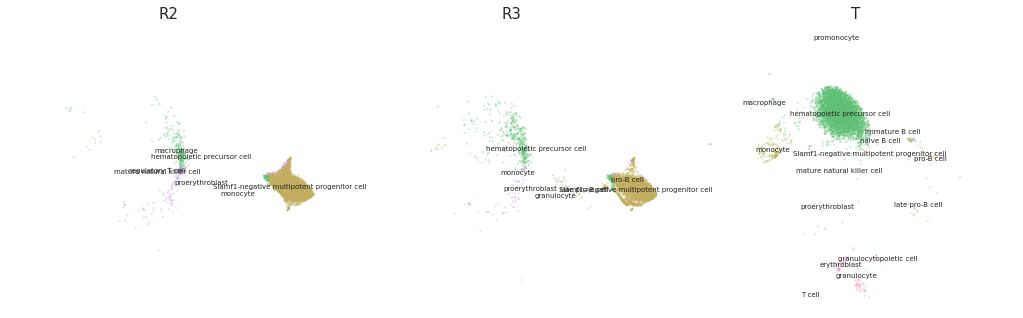

In [786]:

g = sns.relplot(x = unfiltered.obsm['X_umap'][:,0],
                y = unfiltered.obsm['X_umap'][:,1], 
                hue = unfiltered.obs.scNym,
                col= unfiltered.obs.Study,
                col_order=['R2','R3','T'],
                rasterized=True,
                legend = False,
                s = 1200000/unfiltered.shape[0],
                alpha=.3)
for ax, study in zip(g.fig.axes,g.col_names):
    ax.axis('off')
    tmp_adata = unfiltered[unfiltered.obs.Study==study]
    centroids = pd.concat([pd.DataFrame(tmp_adata.obsm['X_umap'],
                            columns=['UMAP1','UMAP2'],
                            index=tmp_adata.obs_names),
               unfiltered.obs['scNym']],
              axis=1).groupby('scNym').mean().dropna()
    for row in centroids.itertuples():
        ax.text(row.UMAP1,
                row.UMAP2, 
                row.Index,
                fontsize=7, 
                ha='center',
                va='center')
g.set_titles('{col_name}')
g.savefig('/home/bharris/pseudotime/figures/integration/removed_dataset_cell_types.pdf',transparent=True)

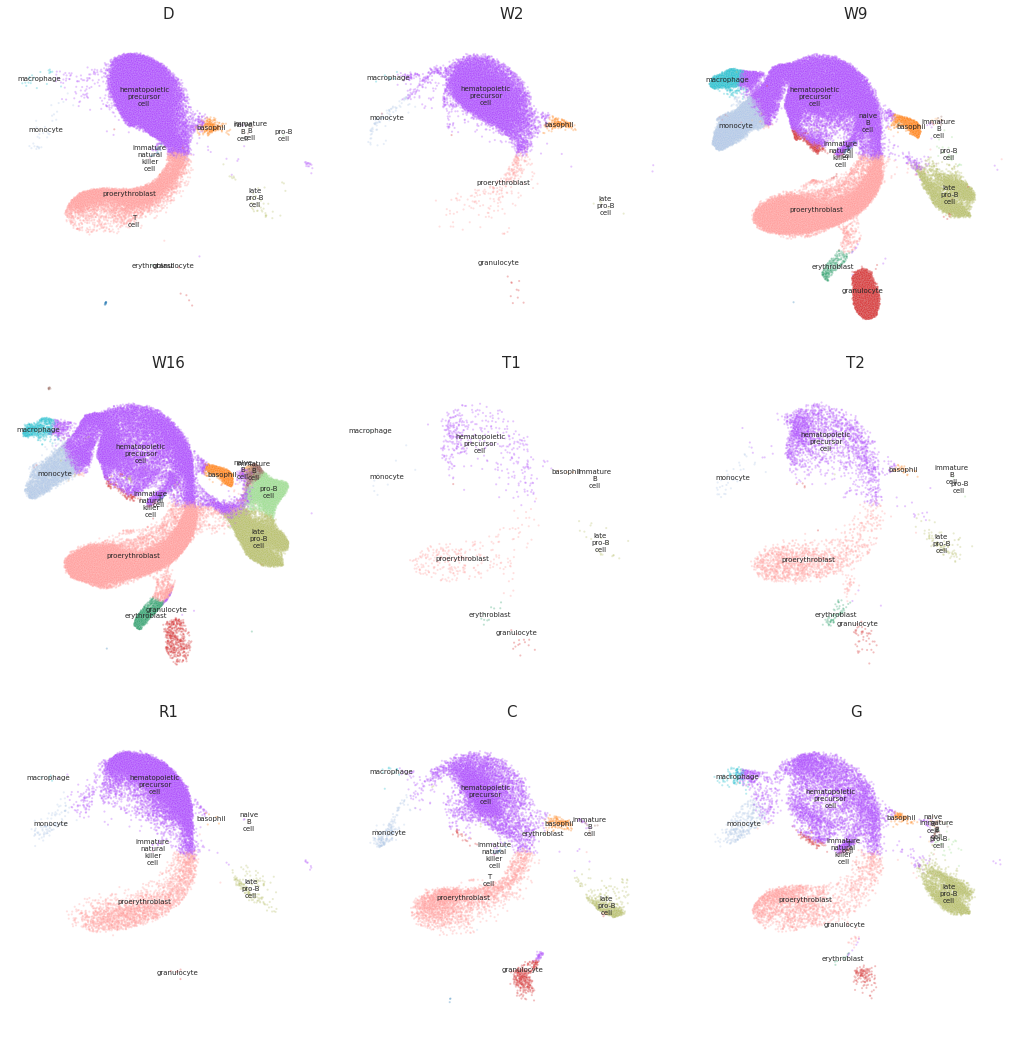

In [769]:

g = sns.relplot(x = all_droplet.obsm['X_umap'][:,0],
                y = all_droplet.obsm['X_umap'][:,1], 
                hue = all_droplet.obs.scNym,
                col= all_droplet.obs.Study,
                col_order=all_droplet.obs.Study.unique(),
                rasterized=True,
                legend = False,
                s = 1200000/all_droplet.shape[0],
                col_wrap=3,
                palette=scNym_pal,
                alpha=.3)
for ax, study in zip(g.fig.axes,g.col_names):
    ax.axis('off')
    tmp_adata = all_droplet[all_droplet.obs.Study==study]
    centroids = pd.concat([pd.DataFrame(tmp_adata.obsm['X_umap'],
                            columns=['UMAP1','UMAP2'],
                            index=tmp_adata.obs_names),
               all_droplet.obs['scNym']],
              axis=1).groupby('scNym').mean().dropna()
    for row in centroids.itertuples():
        ax.text(row.UMAP1,
                row.UMAP2, 
                row.Index.replace(' ','\n'),
                fontsize=7, 
                ha='center',
                va='center')
g.set_titles('{col_name}')
g.savefig('/home/bharris/pseudotime/figures/integration/included_cell_types.pdf',
          transparent=True)

## MetaNeighbor and Marker Enrichment

In [103]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_annots = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                        index_col='X')
go_annots.columns = ['idx', 'description', 'category']
go_annots.index.name = 'GO Term'
go_annots.drop(columns='idx', inplace=True)
go_annots.head()

,description,category
GO Term,,
GO:0000001,mitochondrion inheritance,biological_process
GO:0000002,mitochondrial genome maintenance,biological_process
GO:0000003,reproduction,biological_process
GO:0000005,obsolete ribosomal chaperone activity,molecular_function
GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function


In [104]:
go_used  = go_mouse.reindex(all_droplet.var_names).fillna(0)
go_sizes = go_used.sum()
go_used  = go_used.loc[:,(go_sizes >= 10) & (go_sizes <= 100)]

In [111]:
%%time
mkl.set_num_threads(16)
all_droplet.obs['Cluster'] = all_droplet.obs.scNym.astype(str)
all_droplet.obs.study_id = all_droplet.obs.study_id.astype(str)
mn_res = pymn.MetaNeighbor(all_droplet,
                  'study_id',
                  'Cluster',
                  go_used, 
                  fast_hi_mem=True, 
                  fast_version=True,
                  save_uns=False)
mn_res.index.name ='Cell Type'

CPU times: user 1d 19h 8min 20s, sys: 2h 40min 30s, total: 1d 21h 48min 51s
Wall time: 3h 39min 48s


In [915]:
mn_res.T

Cell Type,T cell,basophil,erythroblast,granulocyte,hematopoietic precursor cell,immature B cell,immature natural killer cell,late pro-B cell,macrophage,monocyte,naive B cell,pro-B cell,proerythroblast
GO:0000002,0.911459,0.618756,0.629823,0.865080,0.513485,0.602585,0.875274,0.652506,0.693305,0.704357,0.554793,0.744733,0.631166
GO:0000014,0.568676,0.518173,0.631650,0.682655,0.510469,0.593345,0.663146,0.574578,0.573976,0.513715,0.606339,0.641378,0.562555
GO:0000018,0.897928,0.711833,0.748318,0.881053,0.681145,0.775296,0.913725,0.633950,0.768392,0.782470,0.675894,0.795828,0.813547
GO:0000027,0.679426,0.670312,0.765494,0.819935,0.567087,0.576220,0.695780,0.592280,0.666670,0.616904,0.638778,0.655046,0.650192
GO:0000028,0.735710,0.665862,0.827323,0.823338,0.537000,0.632972,0.699841,0.552065,0.664538,0.556898,0.601251,0.804567,0.715230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001243,0.831744,0.710905,0.940985,0.975785,0.657721,0.975975,0.872015,0.833563,0.843964,0.954519,0.964218,0.894756,0.818423
GO:2001244,0.897759,0.644476,0.616961,0.981014,0.588129,0.828015,0.897855,0.716639,0.729262,0.714941,0.614733,0.862361,0.718813
GO:2001251,0.780560,0.694417,0.836807,0.884658,0.734941,0.843792,0.766922,0.798354,0.785184,0.748892,0.757031,0.921386,0.826311
GO:2001258,0.725510,0.577711,0.744931,0.938136,0.568943,0.712405,0.725253,0.709091,0.728265,0.672598,0.685371,0.782554,0.605749


In [547]:
terms_less_than_20 = go_annots.reindex(go_used.columns[go_used.sum()<=20])['description'].dropna().values

mn_res_less_than_20 = (mn_res[go_annots
                              .reset_index()
                              .set_index('description')
                              .loc[terms_less_than_20, 'GO Term'].values])
top_small_terms = (mn_res_less_than_20
 .rank(ascending=False,axis=1)
 .reset_index()
 .melt(id_vars='Cell Type',
       value_name='auroc_rank',
       var_name='GO Term')
 .query('auroc_rank<=5'))
top_small_terms['description'] = go_annots.loc[top_small_terms['GO Term'].values,'description'].values

top_small_terms.sort_values(['Cell Type','auroc_rank']).query('auroc_rank<3')

,Cell Type,GO Term,auroc_rank,description
12389,T cell,GO:0031233,1.0,intrinsic component of external side of plasma...
14690,T cell,GO:0033630,2.0,positive regulation of cell adhesion mediated ...
14275,basophil,GO:0033008,1.5,positive regulation of mast cell activation in...
17876,basophil,GO:0043306,1.5,positive regulation of mast cell degranulation
15576,erythroblast,GO:0035067,1.0,negative regulation of histone acetylation
1211,erythroblast,GO:0001921,2.0,positive regulation of receptor recycling
18359,granulocyte,GO:0044215,2.0,obsolete other organism
18372,granulocyte,GO:0044216,2.0,other organism cell
18385,granulocyte,GO:0044217,2.0,other organism part
10950,hematopoietic precursor cell,GO:0022840,1.5,leak channel activity


In [551]:
mn_res.mean().sort_values()

GO:0010485    0.504523
GO:0071855    0.513604
GO:0035249    0.522958
GO:0044447    0.523653
GO:0070897    0.524094
                ...   
GO:0002429    0.919977
GO:0002821    0.920377
GO:0002761    0.920872
GO:0002449    0.925241
GO:0045639    0.927798
Length: 5516, dtype: float64

In [554]:
go_annots.loc['GO:0002761']

description    regulation of myeloid leukocyte differentiation
category                                    biological_process
Name: GO:0002761, dtype: object

In [548]:
term = 'GO:0035162'

mn_res[term].sort_values()

Cell Type
erythroblast                    0.651459
pro-B cell                      0.706224
immature B cell                 0.717417
granulocyte                     0.743749
naive B cell                    0.756466
macrophage                      0.765389
monocyte                        0.791611
basophil                        0.821214
late pro-B cell                 0.825519
hematopoietic precursor cell    0.845477
immature natural killer cell    0.864377
T cell                          0.869496
proerythroblast                 0.933052
Name: GO:0035162, dtype: float64

In [841]:
mn_res.reset_index().melt(id_vars='Cell Type',value_name='AUROC').query('AUROC > .9').groupby('Cell Type').size()

Cell Type
T cell                           329
basophil                         133
erythroblast                     485
granulocyte                     1064
immature B cell                  148
immature natural killer cell     495
late pro-B cell                   84
macrophage                       210
monocyte                         227
naive B cell                     142
pro-B cell                       102
proerythroblast                  148
dtype: int64

In [846]:
mn_res['GO:0035162']

Cell Type
T cell                          0.869496
basophil                        0.821214
erythroblast                    0.651459
granulocyte                     0.743749
hematopoietic precursor cell    0.845477
immature B cell                 0.717417
immature natural killer cell    0.864377
late pro-B cell                 0.825519
macrophage                      0.765389
monocyte                        0.791611
naive B cell                    0.756466
pro-B cell                      0.706224
proerythroblast                 0.933052
Name: GO:0035162, dtype: float64

In [842]:
mn_res.reset_index().melt(id_vars='Cell Type',value_name='AUROC').groupby('Cell Type').mean()

,AUROC
Cell Type,
T cell,0.712016
basophil,0.674772
erythroblast,0.730418
granulocyte,0.801154
hematopoietic precursor cell,0.638899
immature B cell,0.684519
immature natural killer cell,0.722980
late pro-B cell,0.682380
macrophage,0.716786


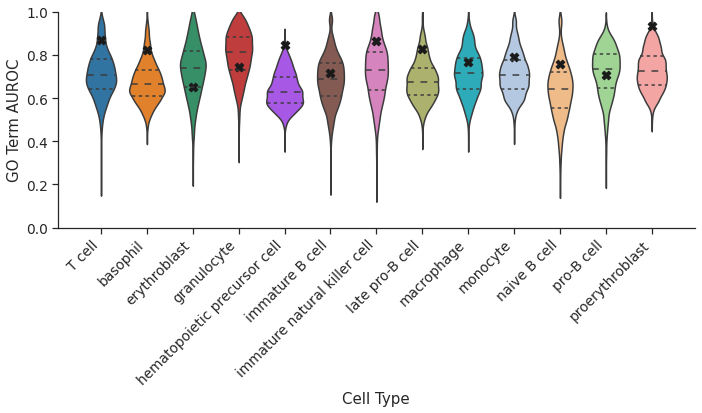

In [802]:
fig ,ax = plt.subplots(figsize=(10,6))
sns.violinplot(data=mn_res.reset_index().melt(id_vars='Cell Type',value_name='AUROC'),
               x='Cell Type',
               y='AUROC', 
               inner='quartile',
               palette=scNym_pal,
               ax=ax,
               edgecolor='0.7',
              order=list(scNym_pal.keys()))
ax.set_xticklabels(ax.get_xticklabels(),ha='right',rotation=45)
ax.set(ylim=[0,1],ylabel='GO Term AUROC')
plt.tight_layout()
for ct in mn_res.index:
    ax.scatter(ct, mn_res.loc[ct, term],s=75,c='k',marker='X')
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/mn_violinplot.pdf',
            transparent=True)

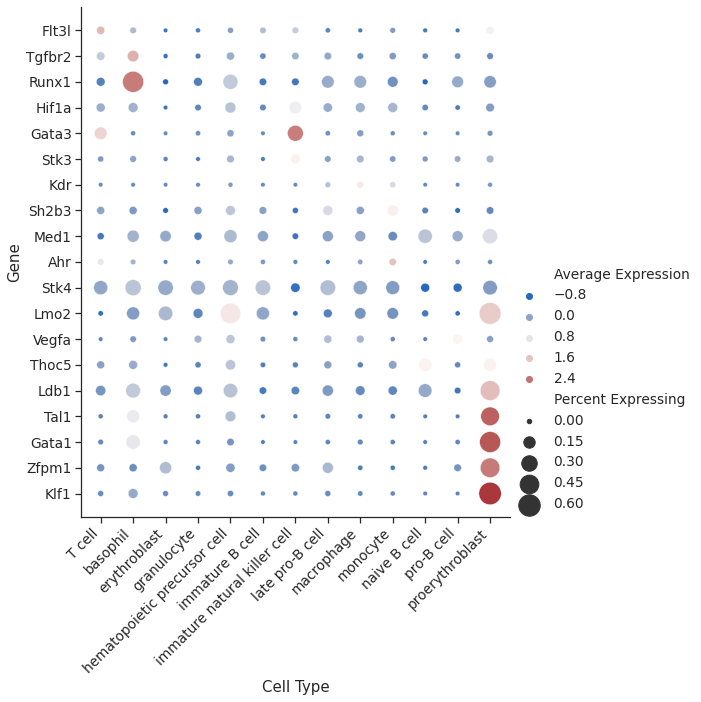

In [607]:
all_droplet.obs.study_id = all_droplet.obs.study_id.astype(str)
all_droplet.obs.scNym = all_droplet.obs.scNym.astype(str)

fig, ax_dot = plt.subplots(figsize=(10,10))
plotDotPlot(all_droplet,
                 pd.Series(np.in1d(all_droplet.var_names,go_used.index[go_used[term].astype(bool)]),
                           index=all_droplet.var_names),
                 study_col='study_id',
                 ct_col='scNym',
                 ax=ax_dot,
                 average_expressing_only=False,
                 normalize_library_size=False,
                 show=False,
                 fontsize=10,
                 sizes=(20,500))

ax_dot.set_xticklabels(ax_dot.get_xticklabels(),ha='right',rotation=45)
plt.tight_layout()
plt.savefig(f'/home/bharris/pseudotime/figures/scNym_cluster_figures/mn_dotplot_{term}.pdf',
            transparent=True)

In [609]:
go_annots.loc[term]

description    embryonic hemopoiesis
category          biological_process
Name: GO:0035162, dtype: object

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


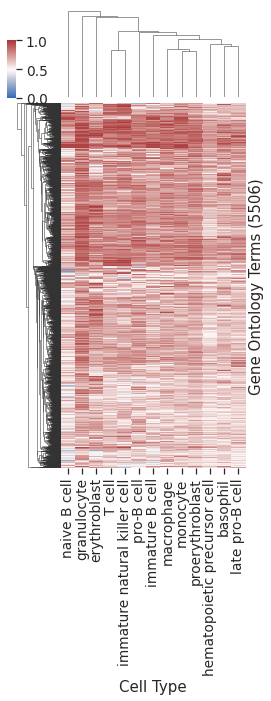

In [198]:
cg = sns.clustermap(mn_res.dropna(axis=1).T,
                    cmap='vlag',
                    vmin=0,
                    vmax=1,
                   cbar_pos=(0.025, .85, 0.025, 0.08),
                   xticklabels=True,
                   figsize=(5,10))
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set(ylabel=f'Gene Ontology Terms ({mn_res.dropna(axis=1).shape[1]})')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(),rotation=90)
cg.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/metaneighbor_all_GO.pdf',
            transparent=True)

In [928]:
scNym_markers.to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_1.csv')

In [15]:
scNym_markers = pd.read_csv('~/pseudotime/data/markers/droplet_scNym_metamarkers.csv.gz',skiprows=1)
scNym_markers = scNym_markers[scNym_markers.cell_type.isin(all_droplet.obs.scNym.unique())]
pareto_genes = []
min_recurrence = 3
for ct in scNym_markers.cell_type.unique():
    find_pareto = scNym_markers.query('recurrence >= @min_recurrence & cell_type == @ct')
    front = find_pareto[['auroc','fold_change_detection']].sort_values(['auroc','fold_change_detection'], ascending=[False,False])
    par_genes = find_pareto[front.fold_change_detection >= np.maximum.accumulate(front.fold_change_detection)].sort_values('fold_change_detection')
    pareto_genes.append(par_genes)
pareto_genes = pd.concat(pareto_genes)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bharris/mi

In [88]:
top_50_markers = 1 - (scNym_markers.query('rank <=50').pivot(index='gene',columns='cell_type',values='rank').isna() * 1)
top_50_markers.to_csv('/home/bharris/pseudotime/data/markers/droplet_top_50_markers_design.csv')

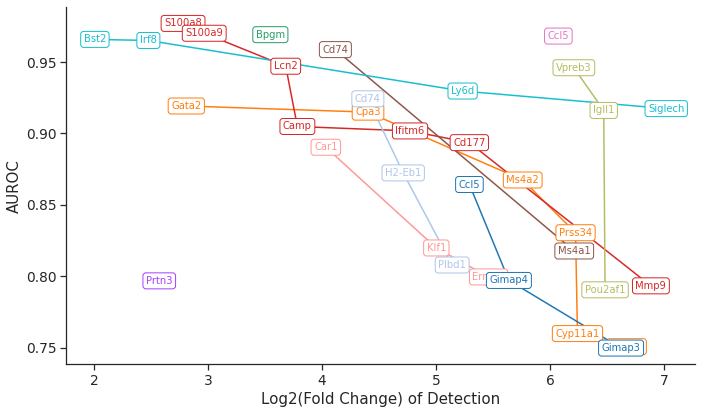

In [57]:
fig ,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(x=np.log2(pareto_genes.fold_change_detection),
                     y=pareto_genes.auroc,
                     hue=pareto_genes.cell_type,
                     palette=scNym_pal,
                     sort=False,
                     legend=None)
#ax.legend(loc=(1,0),frameon=False)
ax.set(xlabel='Log2(Fold Change) of Detection',
      ylabel='AUROC')
for row in pareto_genes.itertuples():
    ax.text(np.log2(row.fold_change_detection),
             row.auroc , 
        row.gene, 
        size=10,
        ha='center',
        va='center',
        color=scNym_pal[row.cell_type],
        bbox=dict(boxstyle='round',
                  facecolor='white',
                  edgecolor=scNym_pal[row.cell_type]))
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/scnym_top_marker_pareto.pdf',
            transparent=True)

In [678]:
marker_df = pd.read_csv('/home/bharris/pseudotime/data/markers/marker_droplet_top_genes_heatmap.csv',index_col=0)

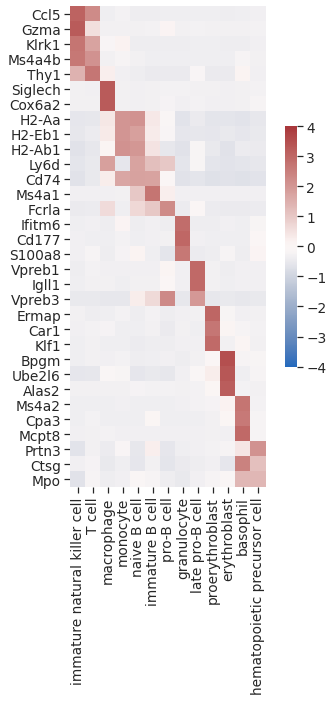

In [696]:
fig, ax = plt.subplots(figsize=(6,10))
sns.heatmap(marker_df,
            cmap='vlag',
            ax=ax,
           cbar_kws={'shrink':.5},
            vmin=-4,
            vmax=4,
           square=True)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/scNym_cluster_figures/scNym_marker_heatmap_python.pdf',
            transparent=True)

In [918]:
supp = mn_res.T.copy()

In [924]:
supp.insert(0,'Description',go_annots.reindex(supp.index.values)['description'].values)

In [927]:
supp.dropna().to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_2.csv.gz')